# Install required packages and set up environment if needed

In [1]:
import pandas as pd

from momentum_backtester.adapters.sp500_github_adapter import load_tiny_sample, load_sp500_data_wrds
from momentum_backtester.backtester import Backtester
from momentum_backtester.signals import price_momentum
from momentum_backtester.ranking import cross_sectional_rank
from momentum_backtester.aggregation import long_short_top_bottom_sector_neutral, long_only
from momentum_backtester.costs import turnover_costs
from momentum_backtester.analysis import Analysis

# Load the required data for backtesting

In [2]:
# WRDS
# refer from another package: https://github.com/ZhengGong-hub/academic_data_download
data = load_sp500_data_wrds(start_year=2009, end_year=2024)

Loading SP500 data...
Connecting to WRDS with username: zhenggong123
Loading library list...
Done
Connected to WRDS!
Loading SP500 data for year 2009...
the number of unique permnos for year 2009 is 493
the number of unique gvkeys for year 2009 is 493
Loading SP500 data for year 2010...
the number of unique permnos for year 2010 is 496
the number of unique gvkeys for year 2010 is 496
Loading SP500 data for year 2011...
the number of unique permnos for year 2011 is 496
the number of unique gvkeys for year 2011 is 495
Loading SP500 data for year 2012...
the number of unique permnos for year 2012 is 495
the number of unique gvkeys for year 2012 is 494
Loading SP500 data for year 2013...
the number of unique permnos for year 2013 is 493
the number of unique gvkeys for year 2013 is 492
Loading SP500 data for year 2014...
the number of unique permnos for year 2014 is 495
the number of unique gvkeys for year 2014 is 494
Loading SP500 data for year 2015...
the number of unique permnos for year

In [3]:
# let's have a look at the data 
sp500_universes = data["sp500_universes"][0]
sp500_universes

SP500Universe(year=2009, gvkeys=<StringArray>
['012136', '012142', '012141', '001279', '012138', '001300', '012053',
 '001408', '012216', '012233',
 ...
 '175263', '176282', '177376', '177264', '177267', '178310', '179621',
 '179700', '010903', '180167']
Length: 493, dtype: string, permnos=<IntegerArray>
[10078, 10104, 10107, 10137, 10138, 10145, 10147, 10225, 10299, 10324,
 ...
 91461, 91650, 92121, 92156, 92157, 92293, 92602, 92618, 92655, 92709]
Length: 493, dtype: Int64)

In [5]:
# let's have a look at the data
# return df 
# we have two types of return_df:
# 1. retoto_df_wide: open-to-open return
# 2. retctc_df_wide: close-to-close return
retoto_df_wide = data["retoto_df_wide"]
retctc_df_wide = data["retctc_df_wide"]

# price df
# we have two types of price_df:
# 1. adjclose_df_wide: adjusted close price
# 2. adjopen_df_wide: adjusted open price
adjclose_df_wide = data["adjclose_df_wide"]
adjopen_df_wide = data["adjopen_df_wide"]

# sector df
sector_df_wide = data["sector_df_wide"]

# let's have a look at the data
# retoto_df_wide.tail()
# retctc_df_wide.tail()
# adjclose_df_wide.tail()
adjopen_df_wide.tail()
# sector_df_wide.tail()

permno,10078,10104,10107,10137,10138,10145,10147,10225,10299,10324,...,92988,93002,93089,93096,93132,93159,93246,93422,93429,93436
date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,<NA>,169.7,434.64999,<NA>,115.26,226.64999,<NA>,<NA>,<NA>,<NA>,...,<NA>,240.11501,276.17999,74.5,96.65,<NA>,153.5,<NA>,193.09,435.89999
2024-12-26,<NA>,170.5,439.07999,<NA>,116.88,228.78,<NA>,<NA>,<NA>,<NA>,...,<NA>,240.0,277.26001,74.75,97.16,<NA>,154.47,<NA>,193.78,465.16
2024-12-27,<NA>,170.38,434.60001,<NA>,116.58,231.0,<NA>,<NA>,<NA>,<NA>,...,<NA>,245.64,276.54001,75.39,96.51,<NA>,154.92,<NA>,195.87,449.51999
2024-12-30,<NA>,166.50999,426.06,<NA>,114.32,227.14999,<NA>,<NA>,<NA>,<NA>,...,<NA>,234.69501,276.79999,75.77,94.88,<NA>,153.86,<NA>,197.2,419.39999
2024-12-31,<NA>,167.2,426.10001,<NA>,114.5,227.14999,<NA>,<NA>,<NA>,<NA>,...,<NA>,235.88,276.45001,75.69,95.79,<NA>,155.0,<NA>,196.39999,423.79001


# Run the backtester

In [6]:
bt = Backtester(
    retoto_df_wide=retoto_df_wide,
    retctc_df_wide=retctc_df_wide,
    adjclose_df_wide=adjclose_df_wide,
    adjopen_df_wide=adjopen_df_wide,
    sector_df_wide=sector_df_wide,
    signal=lambda px: price_momentum(
        px, 
        lookback_months=11, 
        skip=1),
    ranker=cross_sectional_rank,
    aggregator=lambda ranks, sectors: long_short_top_bottom_sector_neutral(
        ranks, 
        sectors, 
        top_pctg=20, 
        bottom_pctg=20),
    costs=lambda w: turnover_costs(w, 10.0),
    rebal_freq="M",
)
results = bt.run()

In [6]:
# peek 
results.keys()
# results

dict_keys(['weights', 'signal', 'ranks', 'gross_returns', 'transaction_costs', 'net_returns', 'equity', 'retoto_df_wide'])

In [7]:
# quick summary
summary = {
    "start": results["net_returns"].index.min(),
    "end": results["net_returns"].index.max(),
    "n_days": int(results["net_returns"].shape[0]),
    "cum_return": float((1 + results["net_returns"]).prod() - 1.0),
}
summary

{'start': Timestamp('2009-01-02 00:00:00'),
 'end': Timestamp('2024-12-31 00:00:00'),
 'n_days': 4026,
 'cum_return': 0.18407566973785716}

# Run analysis on the backtest results


In [8]:
# load in analysis class
analysis = Analysis(output_dir="output")

In [9]:
cagr = analysis.cagr(results["net_returns"], 252, verbose=False)
print("the CAGR is: ", cagr)

the CAGR is:  0.0106


In [34]:
vol = analysis.annual_vol(results["net_returns"], periods_per_year=252, verbose=False)
print("the annual volatility is: ", vol)

the annual volatility is:  0.1298


In [10]:
sharpe = analysis.sharpe(results["net_returns"], risk_free=0.0, periods_per_year=252, verbose=False)
print("the Sharpe ratio is: ", sharpe)

the Sharpe ratio is:  0.1467


In [11]:
mdd = analysis.max_drawdown(results["net_returns"], verbose=False)
print("the maximum drawdown is: ", mdd)

the maximum drawdown is:  -0.4979


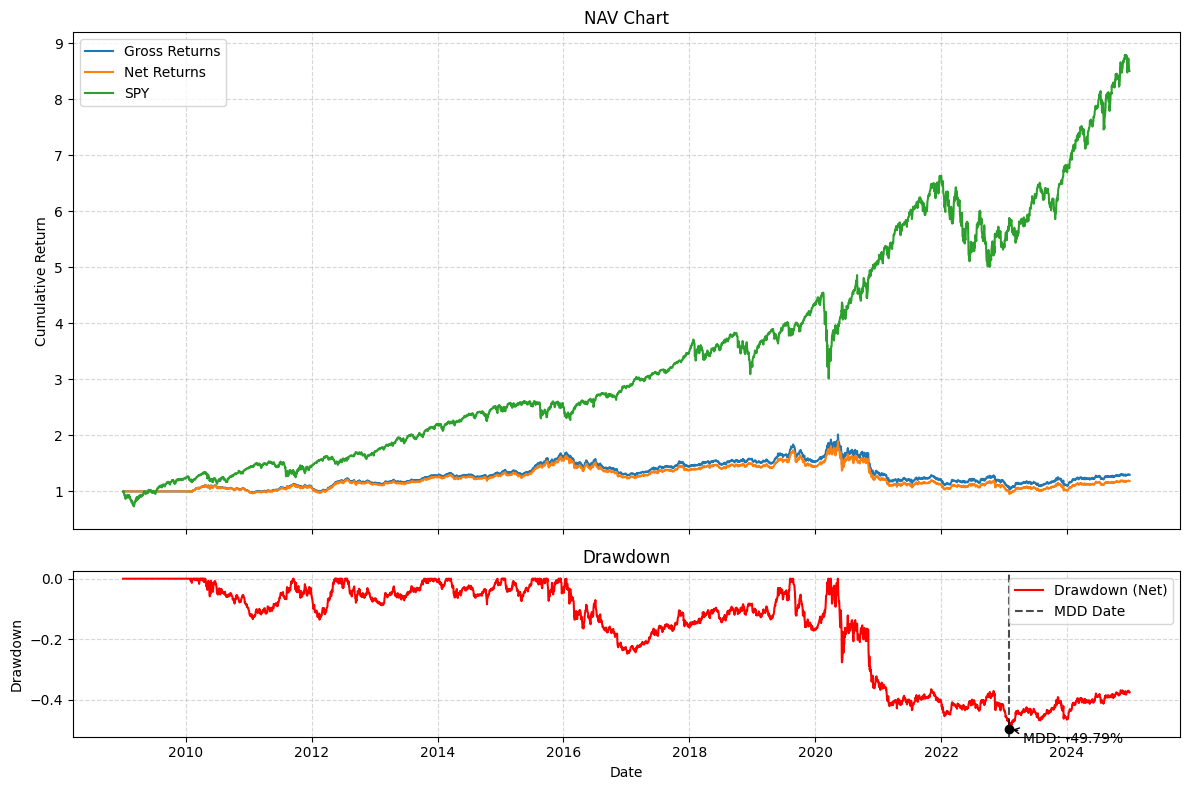

In [37]:
analysis.nav_chart(
    results["gross_returns"], 
    results["net_returns"], 
    incl_spy=True, 
    spy_daily=data["spy_daily"])

In [38]:
analysis.against_spy(results["net_returns"], data["spy_daily"], verbose=False)

{'alpha_annual': 0.0264,
 'beta': -0.0486,
 'alpha_per_period': 0.0001,
 'r2': 0.0044}

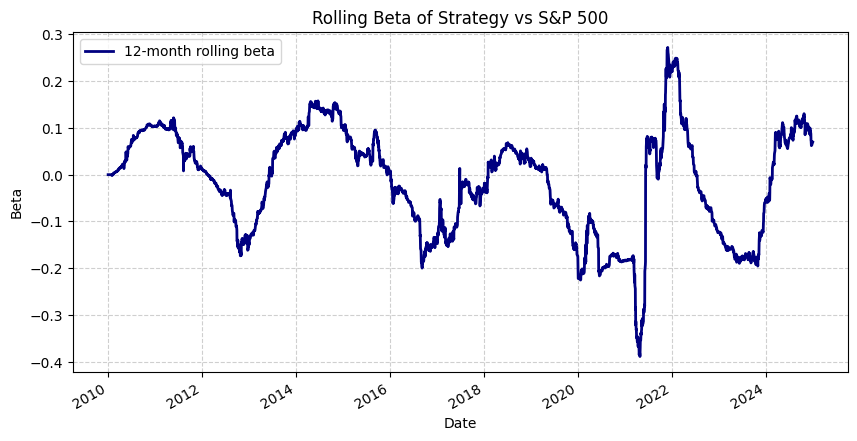

In [39]:
analysis.rolling_beta(results["net_returns"], data["spy_daily"])

In [13]:
attr_sector = analysis.return_attr_sector(
    results["weights"], 
    data["sector_df_wide"], 
    results["retoto_df_wide"], 
    results["gross_returns"],
    verbose=False
    )[:-2]
attr_sector


2024-12-31 00:00:00
20   -0.015287
40   -0.000097
45    0.090292
35    0.031652
25    0.065686
30    0.009635
60    0.031724
55    0.009373
15     0.05685
50    0.043842
10   -0.039473
dtype: object

date
2009-12-31     0.000000
2010-12-31    13.433823
2011-12-31    13.148230
2012-12-31    11.003175
2013-12-31    11.750397
2014-12-31    12.207694
2015-12-31    11.193399
2016-12-31    12.060379
2017-12-31    12.313931
2018-12-31    10.865430
2019-12-31    12.221739
2020-12-31    11.108696
2021-12-31    13.585086
2022-12-31    12.340474
2023-12-31    12.049928
2024-12-31    12.319149
Freq: YE-DEC, dtype: float64

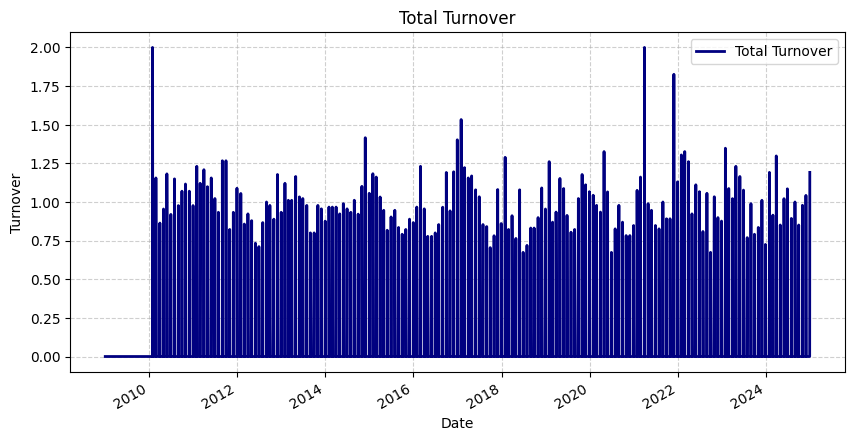

In [14]:
analysis.total_turnover(results["weights"], verbose=False)